In [5]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTENC


In [9]:

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    清洗规则：
    1) 丢掉关键字段有缺失的行
    2) *_ltime 和 *_lflux 缺失填 0
    3) 其余残留缺失全部丢掉
    4) 数值型变量标准化 (z-score)
    """
    key_fields = ["is_local","is_core","arpu","brand","gender","age","id_area"]
    df = df.dropna(subset=[c for c in key_fields if c in df.columns]).copy()

    usage_cols = [c for c in df.columns if c.endswith("_ltime") or c.endswith("_lflux")]
    for c in usage_cols:
        df[c] = df[c].fillna(0)

    df = df.dropna(axis=0)  # 保险起见，丢掉剩余缺失

    # --- 标准化数值型变量 ---
    num_cols = [c for c in df.select_dtypes(include=["number"]).columns if c != "is_blue"]
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df

def encode_categoricals(df: pd.DataFrame, cat_like_cols=None):
    """
    LabelEncoder 编码字符串/类别型字段。
    默认会找 object 类型的列，并额外处理传入的 cat_like_cols。
    """
    encoders = {}
    if cat_like_cols is None:
        cat_like_cols = []

    obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
    for c in cat_like_cols:
        if c in df.columns and c not in obj_cols:
            obj_cols.append(c)

    obj_cols = [c for c in obj_cols if c in df.columns and c != "is_blue"]

    for c in obj_cols:
        le = LabelEncoder()
        df[c] = le.fit_transform(df[c].astype(str))
        encoders[c] = le
    return df, encoders


def train_models(X_train, y_train, seed=42):
    """训练 Decision Tree 和 XGBoost"""
    dt = DecisionTreeClassifier(
        max_depth=8, min_samples_split=50, min_samples_leaf=25, random_state=seed
    )
    dt.fit(X_train, y_train)

    xgb = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.08,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=seed,
        objective="binary:logistic",
        eval_metric="auc",
    )
    xgb.fit(X_train, y_train)
    return dt, xgb

def feature_importance_frame(model, feature_names, kind: str):
    """输出特征重要性 DataFrame"""
    col = "importance" if kind == "dt" else "gain_importance"
    importances = getattr(model, "feature_importances_", None)
    return (pd.DataFrame({"feature": feature_names, col: importances})
              .sort_values(col, ascending=False)
              .reset_index(drop=True))

def barplot_topk(df_imp: pd.DataFrame, col: str, title: str, k: int = 20):
    """绘制前k个特征重要性"""
    top = df_imp.head(k)[::-1]
    plt.figure(figsize=(8, 8))
    plt.barh(top["feature"], top[col])
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
# 路径设置（换成你自己的文件路径）
csv0 = "is_blue=0.csv"
csv1 = "is_blue=1.csv"

# 读取并拼接
df0 = pd.read_csv(csv0)
df1 = pd.read_csv(csv1)
df = pd.concat([df0, df1], ignore_index=True)

# 清洗
df_clean = clean_data(df)

# 编码
cat_like_cols = ["is_local","is_core","brand","gender","id_area","age"]
df_clean, _ = encode_categoricals(df_clean, cat_like_cols=cat_like_cols)

# 分割数据
X = df_clean.drop(columns=["is_blue"])
y = df_clean["is_blue"].astype(int)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [11]:
# 计算 SMOTENC 的类别列索引
categorical_cols = [c for c in cat_like_cols if c in X.columns]
cat_idx = [X.columns.get_loc(c) for c in categorical_cols]

# 使用 SMOTENC：对少数类进行合成过采样到 1:1（sampling_strategy='auto' 即与多数类持平）
sm = SMOTENC(
    categorical_features=cat_idx,
    sampling_strategy='auto',   # 直接拉平到与多数类一样多
    random_state=42,
)
Xtr_res, ytr_res = sm.fit_resample(Xtr, ytr)

print("过采样后训练集类别分布：", np.bincount(ytr_res))
print("训练集样本数：过采样前", Xtr.shape[0], "-> 过采样后", Xtr_res.shape[0])

过采样后训练集类别分布： [2842 2842]
训练集样本数：过采样前 3057 -> 过采样后 5684


Decision Tree AUC: 0.6517883318674875
XGBoost AUC: 0.7085532102022867

=== Decision Tree Report ===
              precision    recall  f1-score   support

           0     0.1455    0.4375    0.2184       144
           1     0.9496    0.8047    0.8712      1895

    accuracy                         0.7788      2039
   macro avg     0.5475    0.6211    0.5448      2039
weighted avg     0.8928    0.7788    0.8251      2039


=== XGBoost Report ===
              precision    recall  f1-score   support

           0     0.3545    0.2708    0.3071       144
           1     0.9456    0.9625    0.9540      1895

    accuracy                         0.9137      2039
   macro avg     0.6501    0.6167    0.6305      2039
weighted avg     0.9038    0.9137    0.9083      2039



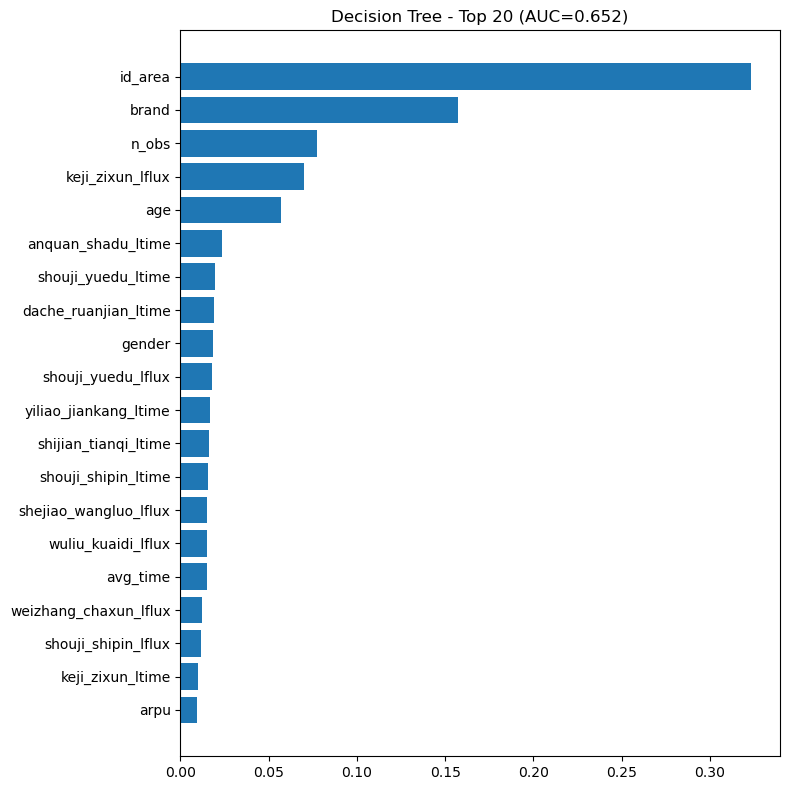

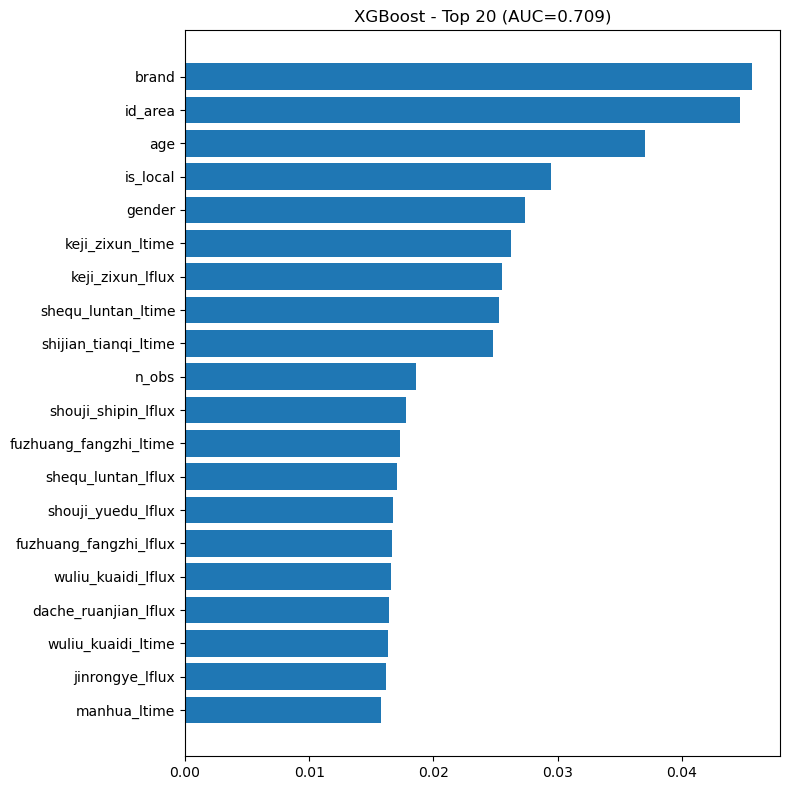

In [15]:
# 训练
dt, xgb = train_models(Xtr_res, ytr_res, seed=42)

# 预测 + AUC
yproba_dt = dt.predict_proba(Xte)[:, 1]
yproba_xgb = xgb.predict_proba(Xte)[:, 1]
y_pred_dt = dt.predict(Xte)
y_pred_xgb = xgb.predict(Xte)

auc_dt = roc_auc_score(yte, yproba_dt)
auc_xgb = roc_auc_score(yte, yproba_xgb)

print("Decision Tree AUC:", auc_dt)
print("XGBoost AUC:", auc_xgb)

# 分类报告
print("\n=== Decision Tree Report ===")
print(classification_report(yte, (yproba_dt >= 0.5).astype(int), digits=4))

print("\n=== XGBoost Report ===")
print(classification_report(yte, (yproba_xgb >= 0.5).astype(int), digits=4))

# 决策树
fi_dt = feature_importance_frame(dt, X.columns, kind="dt")
barplot_topk(fi_dt, "importance", f"Decision Tree - Top 20 (AUC={auc_dt:.3f})")

# XGBoost
fi_xgb = feature_importance_frame(xgb, X.columns, kind="xgb")
barplot_topk(fi_xgb, "gain_importance", f"XGBoost - Top 20 (AUC={auc_xgb:.3f})")


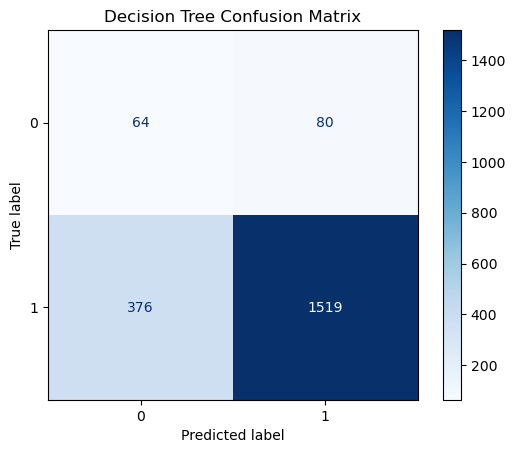

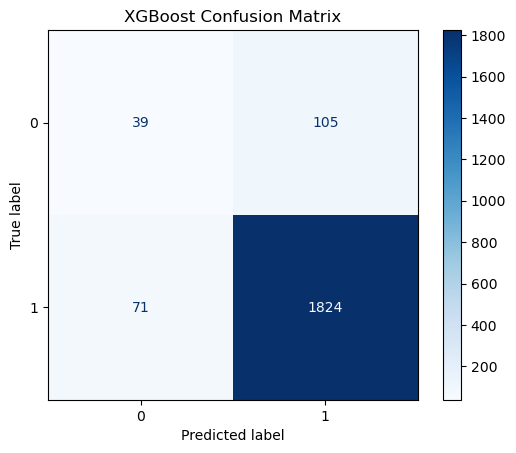

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- 决策树混淆矩阵 ---
cm_dt = confusion_matrix(yte, y_pred_dt)  
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[0,1])
disp_dt.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree Confusion Matrix")
plt.show()

# --- XGBoost混淆矩阵 ---
cm_xgb = confusion_matrix(yte, y_pred_xgb) 
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0,1])
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title("XGBoost Confusion Matrix")
plt.show()